In [1]:
%matplotlib widget
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import h5py 
# from BasisConvolution.util.datautils import parseFile
import os

from state import DataConfiguration
from util import processFolder, getDataLoader
from newFormatLoader import loadFrame_newFormat_v2, convertNewFormatToWCSPH, loadNewFormatState
from loader import loadState
from loader import loadBatch
from neighborhood import neighborSearch, filterNeighborhoodByKind
from tqdm.autonotebook import tqdm

/tmp/ipykernel_479347/1833201310.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# folder = '/mnt/data/homeBak/dev/SFBC/datasets/test_case_II/train/'
# folder = '/mnt/data/homeBak/dev/SFBC/datasets/test_case_III/train/'
# folder = '/mnt/data/dsets/datasetB/export/'
# folder = '/mnt/data/wcsph_datasets/wcsph_flows_free_slip/testing/noObstacle/'
# folder = '/home/winchenbach/dev/datasets/wcsph_flows_no_slip/testing/noObstacle/'
folder = '/home/winchenbach/dev/datasets/testcase_II/'
# folder = './data'
# folder = '/home/winchenbach/dev/datasets/diffSPH_WCSPH/'

# folder = '/home/winchenbach/dev/SFBC/datasets/test_case_II/train/'

In [3]:
configuration = DataConfiguration(
    frameDistance=1,
    frameSpacing=1,
    maxRollout=1,
    historyLength=1,
    skipInitialFrames=0,
    cutoff=0
)

processed = processFolder(folder, configuration)

for file in processed:
    print(f'File: {file["fileName"]}, FrameCount: {len(file["frames"])}, Samples: {len(file["samples"])}, Style: {file["style"]}, Number of samples: {len(processed[0]["samples"])}, first sample: {processed[0]["samples"][0]}, last sample: {processed[0]["samples"][-1]}')


Found 2 simulation files in /home/winchenbach/dev/datasets/testcase_II/, [['generative - 2023-03-22_14-22-55.hdf5', 'generative - 2023-03-22_14-25-43.hdf5']]
File: /home/winchenbach/dev/datasets/testcase_II//generative - 2023-03-22_14-22-55.hdf5, FrameCount: 3197, Samples: 3197, Style: testcase_II, Number of samples: 3197, first sample: 00001, last sample: 03197
File: /home/winchenbach/dev/datasets/testcase_II//generative - 2023-03-22_14-25-43.hdf5, FrameCount: 3197, Samples: 3197, Style: testcase_II, Number of samples: 3197, first sample: 00001, last sample: 03197


In [4]:
dataset, datasetLoader = getDataLoader(processed, 1, shuffle = True)
datasetIter = iter(datasetLoader)

In [5]:
nextData = next(datasetIter)
print(f'Next data: {nextData}')

Next data: [567]


In [6]:
priorStates, currentStates, trajectoryStates, domains, configs = loadBatch(dataset, nextData, configuration, device = 'cuda', dtype = torch.float32)
neighborhoods = []
for state, domain, config in zip(currentStates, domains, configs):
    neighborhood = neighborSearch(state, domain, config)
    neighborhoods.append(neighborhood)

In [7]:
domain = domains[0]
state = currentStates[0]
config = configs[0]

In [8]:
from augment import buildRotationMatrix, augmentDomain, rotateState, getRandomRotationMatrix
from neighborhood import DomainDescription, AugmentedDomainDescription

In [9]:
getRandomRotationMatrix(DomainDescription(
    min = torch.tensor([-1.2, -1.2], device = 'cuda', dtype = torch.float32),
    max = torch.tensor([1.2, 1.2], device = 'cuda', dtype = torch.float32),
    periodic = torch.tensor([False, False], device = 'cuda', dtype = torch.bool),
    dim = 3
))  

Using device: cuda:0, dtype: torch.float32


(tensor([[ 0.2700,  0.9460,  0.1793],
         [ 0.7881, -0.3241,  0.5233],
         [-0.5531,  0.0000,  0.8331]], device='cuda:0'),
 tensor([-1.9009, -2.1569], device='cuda:0'))

In [10]:
domain = DomainDescription(
    min = torch.tensor([-1.2, -1.2], device = 'cuda', dtype = torch.float32),
    max = torch.tensor([1.2, 1.2], device = 'cuda', dtype = torch.float32),
    periodic = torch.tensor([False, False], device = 'cuda', dtype = torch.bool),
    dim = 2
)

augmentAngle = torch.tensor([np.pi / 2], device=domain.min.device, dtype=domain.min.dtype)
rotMat = buildRotationMatrix(augmentAngle, domain.dim, device=domain.min.device, dtype=domain.min.dtype)
# rotMat, angles = getRandomRotationMatrix(domain)
rotatedDomain = augmentDomain(domain, rotMat)


In [11]:
# @dataclass(slots=True)
# class WeaklyCompressibleSPHState:
#     positions: torch.Tensor
#     supports: torch.Tensor
#     masses: torch.Tensor
#     densities: torch.Tensor    
#     velocities: torch.Tensor
    
#     # meta properties for particles
#     kinds: torch.Tensor # 0 for fluid, 1 for boundary, 2 for ghost
#     materials: torch.Tensor # specific subsets of particles, also indicates body id
#     UIDs : torch.Tensor # unique identifiers for particles, ghost particles have negative UIDs

    
#     numParticles: int
#     time: float
#     dt: float
#     timestep: int
#     key: str

#     boundaryNormals: Optional[torch.Tensor] = None
#     boundaryDistances: Optional[torch.Tensor] = None

#     rigidBodies: Optional[List[RigidBodyState]] = None

# @dataclass(slots=True)
# class CompressibleSPHState:
#     positions: torch.Tensor
#     supports: torch.Tensor
#     masses: torch.Tensor
#     densities: torch.Tensor    
#     velocities: torch.Tensor
    
#     # meta properties for particles
#     kinds: torch.Tensor
#     materials: torch.Tensor # specific subsets of particles, also indicates body id
#     UIDs : torch.Tensor # unique identifiers for particles, ghost particles have negative UIDs

#     internalEnergies: torch.Tensor
#     entropies: torch.Tensor
#     pressures: torch.Tensor
#     soundspeeds: torch.Tensor

#     numParticles: int
#     time: float
#     dt: float
#     timestep: int
#     key: str

#     alphas: Optional[torch.Tensor] = None # alpha values for compressible SPH
#     alpha0s: Optional[torch.Tensor] = None # initial alpha values for compressible SPH
#     divergence: Optional[torch.Tensor] = None # divergence of the velocity field

# @dataclass
# class RigidBodyState:
#     bodyID: int
#     kind: str

#     centerOfMass: torch.Tensor
#     orientation: torch.Tensor
#     angularVelocity: torch.Tensor
#     linearVelocity: torch.Tensor
#     mass: torch.Tensor
#     inertia: torch.Tensor

In [12]:
import copy
cState = copy.deepcopy(currentStates[0])

augmentAngle = torch.tensor([np.pi/4], device=domain.min.device, dtype=domain.min.dtype)
rotMat = buildRotationMatrix(augmentAngle, domain.dim, device=domain.min.device, dtype=domain.min.dtype)
# rotMat, angles = getRandomRotationMatrix(domain)
rotatedDomain = augmentDomain(domain, rotMat)


# cState.velocities[:,0] = 1
# cState.velocities[:,1] = 1

augmentedState = rotateState(cState, rotMat)

In [13]:
neighbors = neighborSearch(cState, domain, config)
augmentedNeighbors = neighborSearch(augmentedState, rotatedDomain, config)
augmentedNeighbors2 = neighborSearch(augmentedState, domain, config)

In [14]:
print(f'neighbors: {neighbors.row.shape}, {neighbors.col.shape}, {neighbors.numRows}, {neighbors.numCols}')
print(f'augmentedNeighbors: {augmentedNeighbors.row.shape}, {augmentedNeighbors.col.shape}, {augmentedNeighbors.numRows}, {augmentedNeighbors.numCols}')
print(f'augmentedNeighbors2: {augmentedNeighbors2.row.shape}, {augmentedNeighbors2.col.shape}, {augmentedNeighbors2.numRows}, {augmentedNeighbors2.numCols}')

neighbors: torch.Size([94014]), torch.Size([94014]), 4900, 4900
augmentedNeighbors: torch.Size([94014]), torch.Size([94014]), 4900, 4900
augmentedNeighbors2: torch.Size([89183]), torch.Size([89183]), 4900, 4900


In [15]:
from neighborhood import evalDistanceTensor

In [16]:
evalDistanceTensor(neighbors)

(tensor([0.0000, 0.0333, 0.0323,  ..., 0.0317, 0.0317, 0.0000], device='cuda:0'),
 tensor([[ 0.0000,  0.0000],
         [ 0.0071, -0.0325],
         [-0.0243, -0.0213],
         ...,
         [ 0.0000,  0.0317],
         [ 0.0317,  0.0000],
         [ 0.0000,  0.0000]], device='cuda:0'),
 tensor([0.0795, 0.0795, 0.0795,  ..., 0.0795, 0.0795, 0.0795], device='cuda:0'),
 tensor([0.0795, 0.0795, 0.0795,  ..., 0.0795, 0.0795, 0.0795], device='cuda:0'))

In [17]:
evalDistanceTensor(augmentedNeighbors)

(tensor([0.0000, 0.0333, 0.0323,  ..., 0.0317, 0.0317, 0.0000], device='cuda:0'),
 tensor([[ 0.0000,  0.0000],
         [-0.0180, -0.0280],
         [-0.0322,  0.0022],
         ...,
         [ 0.0224,  0.0224],
         [ 0.0224, -0.0224],
         [ 0.0000,  0.0000]], device='cuda:0'),
 tensor([0.0795, 0.0795, 0.0795,  ..., 0.0795, 0.0795, 0.0795], device='cuda:0'),
 tensor([0.0795, 0.0795, 0.0795,  ..., 0.0795, 0.0795, 0.0795], device='cuda:0'))

In [18]:
augmentedNeighbors2 = copy.deepcopy(augmentedNeighbors)
augmentedNeighbors2.domain = neighbors.domain

print(torch.allclose(evalDistanceTensor(augmentedNeighbors2)[1], evalDistanceTensor(augmentedNeighbors)[1]))


print(evalDistanceTensor(augmentedNeighbors)[1])
print(evalDistanceTensor(augmentedNeighbors2)[1])
diff = evalDistanceTensor(augmentedNeighbors2)[1] - evalDistanceTensor(augmentedNeighbors)[1]

print(f'Difference in distances: {diff}')
print(f'Max difference: {torch.max(diff)}')
print(f'Min difference: {torch.min(diff)}')


False
tensor([[ 0.0000,  0.0000],
        [-0.0180, -0.0280],
        [-0.0322,  0.0022],
        ...,
        [ 0.0224,  0.0224],
        [ 0.0224, -0.0224],
        [ 0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0000,  0.0000],
        [-0.0180, -0.0280],
        [-0.0322,  0.0022],
        ...,
        [ 0.0224,  0.0224],
        [ 0.0224, -0.0224],
        [ 0.0000,  0.0000]], device='cuda:0')
Difference in distances: tensor([[ 0.0000e+00,  0.0000e+00],
        [-2.7940e-08, -7.8231e-08],
        [ 1.4901e-08, -7.9395e-08],
        ...,
        [-9.3132e-09,  1.8626e-09],
        [-5.5879e-09, -5.0291e-08],
        [ 0.0000e+00,  0.0000e+00]], device='cuda:0')
Max difference: 1.7695128917694092e-07
Min difference: -1.7695128917694092e-07


In [19]:
print(torch.all(neighbors.row == augmentedNeighbors.row), torch.all(neighbors.col == augmentedNeighbors.col))

print(torch.all(neighbors.row == augmentedNeighbors2.row), torch.all(neighbors.col == augmentedNeighbors2.col))


tensor(True, device='cuda:0') tensor(True, device='cuda:0')
tensor(True, device='cuda:0') tensor(True, device='cuda:0')


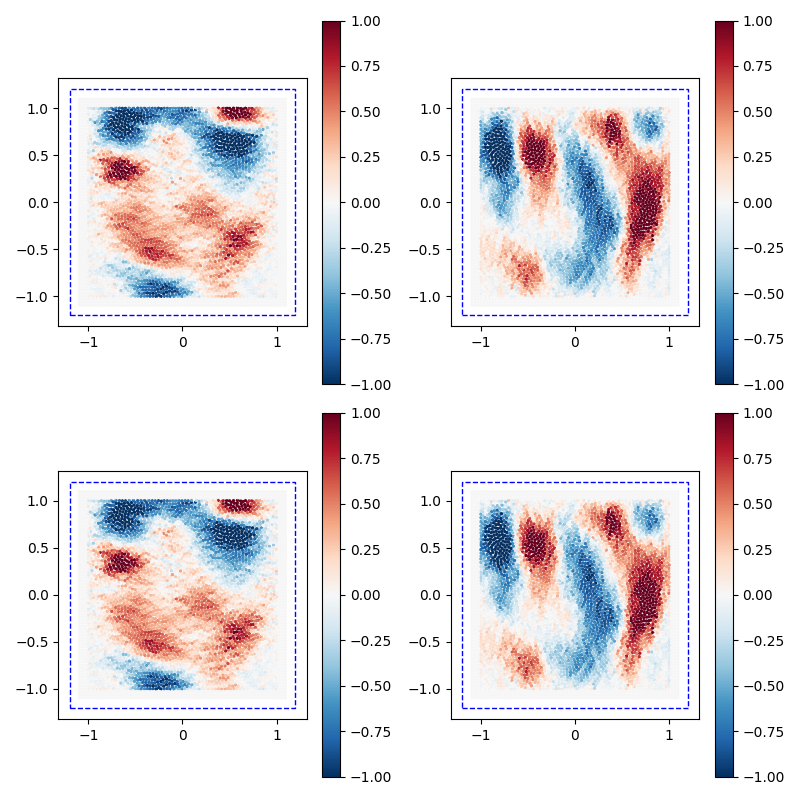

In [20]:
from sphMath.plotting import visualizeParticles
import matplotlib.pyplot as plt


state = cState

fig, axis = plt.subplots(2, 2, figsize=(8, 8), squeeze = False)
filteredNeighborhood = filterNeighborhoodByKind(currentStates[0], neighborhoods[0], 'noghost')

densityPlot = visualizeParticles(fig, axis[0,0],
            particles = state, 
            domain = domain, 
            quantity = state.velocities, 
            which = 'both',
            # operation = 'curl',
            mapping = '.x',
            cmap = 'RdBu_r',
            visualizeBoth=True,
            kernel = config['kernel'],
            plotDomain = True,
            gridVisualization=False, markerSize=2, vmin = -1, vmax = 1)


densityPlot = visualizeParticles(fig, axis[0,1],
            particles = state, 
            domain = domain, 
            quantity = state.velocities, 
            which = 'both',
            # operation = 'curl',
            mapping = '.y',
            cmap = 'RdBu_r',
            visualizeBoth=True,
            kernel = config['kernel'],
            plotDomain = True,
            gridVisualization=False, markerSize=2, vmin = -1, vmax = 1)

state = augmentedState

densityPlot = visualizeParticles(fig, axis[1,0],
            particles = state, 
            domain = rotatedDomain, 
            quantity = state.velocities, 
            which = 'both',
            # operation = 'curl',
            mapping = '.x',
            cmap = 'RdBu_r',
            visualizeBoth=True,
            kernel = config['kernel'],
            plotDomain = True,
            gridVisualization=False, markerSize=2, vmin = -1, vmax = 1)


densityPlot = visualizeParticles(fig, axis[1,1],
            particles = state, 
            domain = rotatedDomain, 
            quantity = state.velocities, 
            which = 'both',
            # operation = 'curl',
            mapping = '.y',
            cmap = 'RdBu_r',
            visualizeBoth=True,
            kernel = config['kernel'],
            plotDomain = True,
            gridVisualization=False, markerSize=2, vmin = -1, vmax = 1)




fig.tight_layout()

(tensor([0.0000, 0.0314, 0.0321,  ..., 0.0317, 0.0317, 0.0000], device='cuda:0'),
 tensor([[ 0.0000e+00,  0.0000e+00],
         [-3.1428e-02,  1.3113e-06],
         [-7.5698e-05, -3.2056e-02],
         ...,
         [ 0.0000e+00,  3.1746e-02],
         [ 3.1746e-02,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]], device='cuda:0'),
 tensor([0.0795, 0.0795, 0.0795,  ..., 0.0795, 0.0795, 0.0795], device='cuda:0'),
 tensor([0.0795, 0.0795, 0.0795,  ..., 0.0795, 0.0795, 0.0795], device='cuda:0'))

In [8]:
from sphMath.operations import sph_op
from sphMath.kernels import getSPHKernelv2
from neighborhood import coo_to_csr

def evalDensity(state, neighborhood, domain, config):
    quantity = torch.ones_like(state.densities)
    return sph_op(
        state, state, domain, getSPHKernelv2('Wendland2'), neighborhood, quantity = quantity, supportScheme='gather', operation = 'density'
    )

filteredNeighborhood = filterNeighborhoodByKind(currentStates[0], neighborhoods[0], 'fluid')
filtered_csr = coo_to_csr(filteredNeighborhood)

rho = evalDensity(currentStates[0], filteredNeighborhood, domains[0], configs[0])

In [9]:
# configs[0]['fluid']['rho0'] 

In [10]:
domains[0]

DomainDescription(min=tensor([-1.2000, -1.2000], device='cuda:0'), max=tensor([1.2000, 1.2000], device='cuda:0'), periodic=tensor([False, False], device='cuda:0'), dim=2)

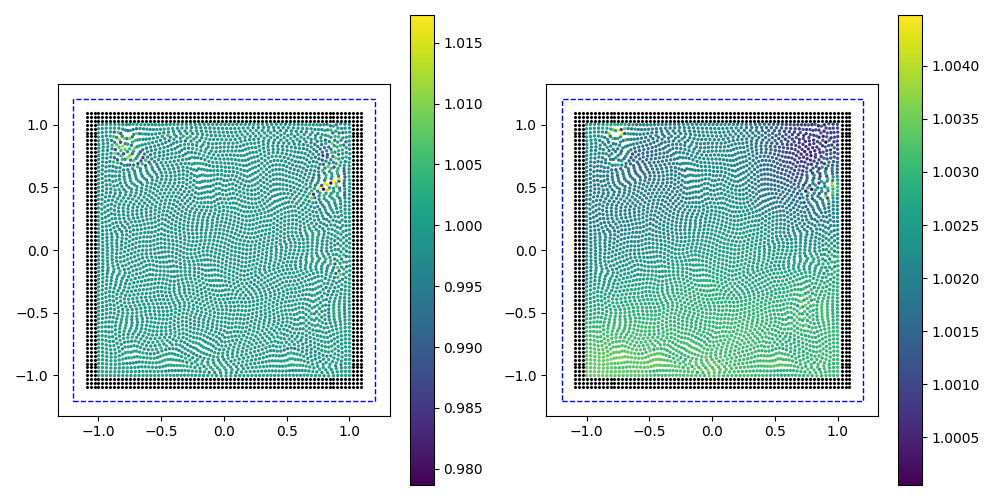

In [53]:
from sphMath.plotting import visualizeParticles
import matplotlib.pyplot as plt


fig, axis = plt.subplots(1, 2, figsize=(10, 5), squeeze = False)

filteredNeighborhood = filterNeighborhoodByKind(currentStates[0], neighborhoods[0], 'noghost')
filtered_csr = coo_to_csr(filteredNeighborhood)
rho = evalDensity(currentStates[0], filteredNeighborhood, domains[0], configs[0])
densityPlot = visualizeParticles(fig, axis[0,0],
            particles = currentStates[0], 
            domain = domains[0], 
            quantity = rho/1000, 
            which = 'fluid',
            # operation = 'curl',
            mapping = '.x',
            cmap = 'viridis',
            visualizeBoth=True,
            kernel = config['kernel'],
            plotDomain = True,
            gridVisualization=False, markerSize=2)

filteredNeighborhood = filterNeighborhoodByKind(currentStates[0], neighborhoods[0], 'noghost')
filtered_csr = coo_to_csr(filteredNeighborhood)
rho = evalDensity(currentStates[0], filteredNeighborhood, domains[0], configs[0])

densityPlot = visualizeParticles(fig, axis[0,1],
            particles = currentStates[0], 
            domain = domains[0], 
            quantity = currentStates[0].densities, 
            which = 'fluid',
            # operation = 'curl',
            mapping = '.x',
            cmap = 'viridis',
            visualizeBoth=True,
            kernel = config['kernel'],
            plotDomain = True,
            gridVisualization=False, markerSize=2)

fig.tight_layout()

In [12]:
from BasisConvolution.convLayerv3 import BasisConvLayer

In [13]:
testLayer = BasisConvLayer(
    inputFeatures = 1,
    outputFeatures = 1,
    dim = domains[0].dim,

    basisTerms = 4,
    basisFunction = 'linear',
    basisPeriodicity = False,

    biasActive= False,
    cutlassBatchSize= 16,

    mode = 'conv'
).to('cuda', dtype = torch.float32)

optimizer = torch.optim.Adam(testLayer.parameters(), lr=1e-3)

In [20]:
inputFeatures = torch.ones_like(currentStates[0].densities).unsqueeze(-1)

filteredNeighborhood = filterNeighborhoodByKind(currentStates[0], neighborhoods[0], 'noghost')
edge_index = torch.stack([filteredNeighborhood.row, filteredNeighborhood.col])
# print(edge_index.shape)

rij, xij_, h_i, h_j = evalDistanceTensor(filteredNeighborhood)
edge_attr = xij_

out, _ = testLayer(
    x = [inputFeatures, inputFeatures],
    edge_index = edge_index,
    edge_attr = edge_attr,
    batches = 1,
)

print(f'Output shape: {out.shape}'
      f', Input shape: {inputFeatures.shape}, Edge index shape: {edge_index.shape}, Edge attr shape: {edge_attr.shape}')

Output shape: torch.Size([4900, 1]), Input shape: torch.Size([4900, 1]), Edge index shape: torch.Size([2, 94824]), Edge attr shape: torch.Size([94824, 2])


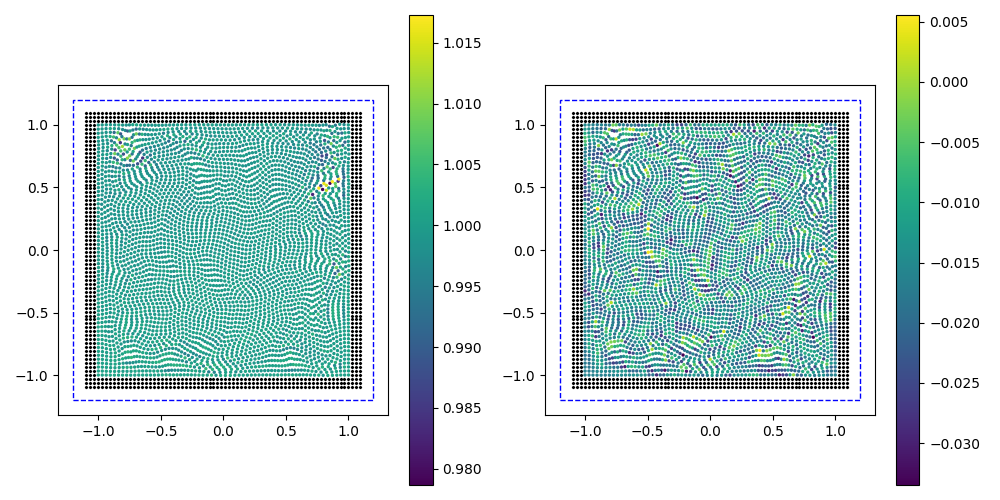

In [15]:
from sphMath.plotting import visualizeParticles
import matplotlib.pyplot as plt


fig, axis = plt.subplots(1, 2, figsize=(10, 5), squeeze = False)

densityPlot = visualizeParticles(fig, axis[0,0],
            particles = currentStates[0], 
            domain = domains[0], 
            quantity = rho / configs[0]['fluid']['rho0'], 
            which = 'fluid',
            # operation = 'curl',
            mapping = '.x',
            cmap = 'viridis',
            visualizeBoth=True,
            kernel = config['kernel'],
            plotDomain = True,
            gridVisualization=False, markerSize=2)

densityPlot = visualizeParticles(fig, axis[0,1],
            particles = currentStates[0], 
            domain = domains[0], 
            quantity = out[:,0], 
            which = 'fluid',
            # operation = 'curl',
            mapping = '.x',
            cmap = 'viridis',
            visualizeBoth=True,
            kernel = config['kernel'],
            plotDomain = True,
            gridVisualization=False, markerSize=2)

fig.tight_layout()

In [90]:
testLayer = BasisConvLayer(
    inputFeatures = 1,
    outputFeatures = 1,
    dim = domains[0].dim,

    basisTerms = 5,
    basisFunction = 'ffourier even',
    basisPeriodicity = False,

    biasActive= False,
    cutlassBatchSize= 16,

    mode = 'conv', edgeSkip = 'ij'
).to('cuda', dtype = torch.float32)

optimizer = torch.optim.Adam(testLayer.parameters(), lr=1e-2)

losses = []

for i in (tq := tqdm(range(2000))):
    try:
        batch = next(datasetIter)
    except StopIteration:
        datasetIter = iter(datasetLoader)
        batch = next(datasetIter)

    priorStates, currentStates, trajectoryStates, domains, configs = loadBatch(dataset, batch, configuration, device = 'cuda', dtype = torch.float32)
    neighborhoods = []
    for state, domain, config in zip(currentStates, domains, configs):
        neighborhood = neighborSearch(state, domain, config)
        neighborhoods.append(neighborhood)

    inputFeatures = torch.ones_like(currentStates[0].densities).unsqueeze(-1)
    # inputFeatures = currentStates[0].masses.unsqueeze(-1)

    filteredNeighborhood = filterNeighborhoodByKind(currentStates[0], neighborhoods[0], 'noghost')
    edge_index = torch.stack([filteredNeighborhood.row, filteredNeighborhood.col])
    # print(edge_index.shape)

    rij, xij_, h_i, h_j = evalDistanceTensor(filteredNeighborhood)
    edge_attr = xij_ / h_i[:,None]



    optimizer.zero_grad()
    out, _ = testLayer(
        x = [inputFeatures, inputFeatures],
        edge_index = edge_index,
        edge_attr = edge_attr,
        batches = 1,
    )

    rho = evalDensity(currentStates[0], filteredNeighborhood, domains[0], configs[0])
    gt = (rho / configs[0]['fluid']['rho0'])
    gt = gt.reshape(-1, 1)

    error = gt - out
    error = error[currentStates[0].kinds == 0]

    loss = torch.sum(error ** 2)
    loss.backward()
    optimizer.step()
    tq.set_description(f'Loss: {loss.item():.4f} [{batch}], Density: {torch.mean(gt):.4f} +- {torch.std(gt):.4f}, Output: {torch.mean(out):.4f} +- {torch.std(out):.4f}, {currentStates[0].time}')
    losses.append(loss.item())
    # print('Loss: ', loss)


  0%|          | 0/2000 [00:00<?, ?it/s]

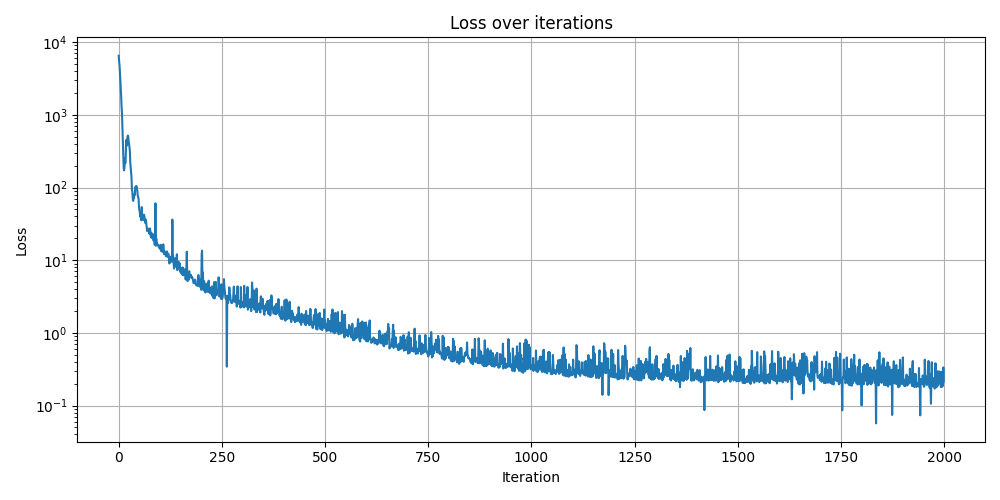

In [91]:
fig, axis = plt.subplots(1, 1, figsize=(10, 5), squeeze = False)

axis[0,0].plot(losses)
axis[0,0].set_title('Loss over iterations')
axis[0,0].set_xlabel('Iteration')
axis[0,0].set_ylabel('Loss')

axis[0,0].grid(True)
axis[0,0].set_yscale('log')
fig.tight_layout()

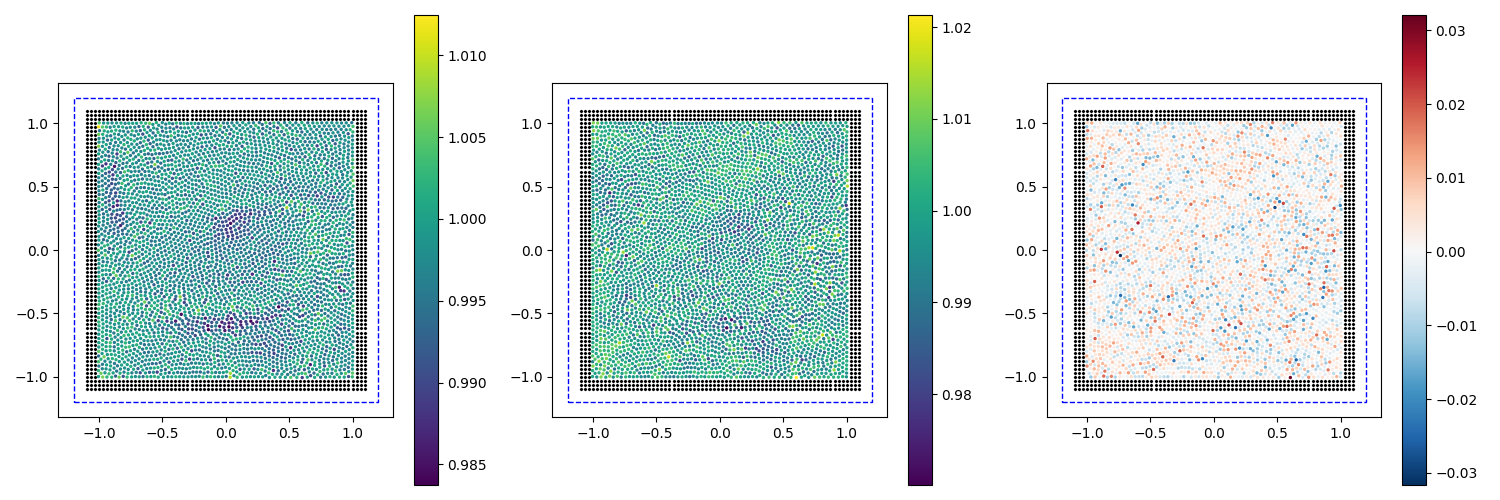

In [92]:
from sphMath.plotting import visualizeParticles
import matplotlib.pyplot as plt


fig, axis = plt.subplots(1, 3, figsize=(15, 5), squeeze = False)

densityPlot = visualizeParticles(fig, axis[0,0],
            particles = currentStates[0], 
            domain = domains[0], 
            quantity = rho / configs[0]['fluid']['rho0'], 
            which = 'fluid',
            # operation = 'curl',
            mapping = '.x',
            cmap = 'viridis',
            visualizeBoth=True,
            kernel = config['kernel'],
            plotDomain = True,
            gridVisualization=False, markerSize=2)

densityPlot = visualizeParticles(fig, axis[0,1],
            particles = currentStates[0], 
            domain = domains[0], 
            quantity = out[:,0], 
            which = 'fluid',
            # operation = 'curl',
            mapping = '.x',
            cmap = 'viridis',
            visualizeBoth=True,
            kernel = config['kernel'],
            plotDomain = True,
            gridVisualization=False, markerSize=2)

densityPlot = visualizeParticles(fig, axis[0,2],
            particles = currentStates[0], 
            domain = domains[0], 
            quantity = out[:,0] - rho / configs[0]['fluid']['rho0'],
            which = 'fluid',
            # operation = 'curl',
            mapping = '.x',
            cmap = 'RdBu_r',
            visualizeBoth=True,
            kernel = config['kernel'],
            plotDomain = True,
            gridVisualization=False, markerSize=2)

fig.tight_layout()

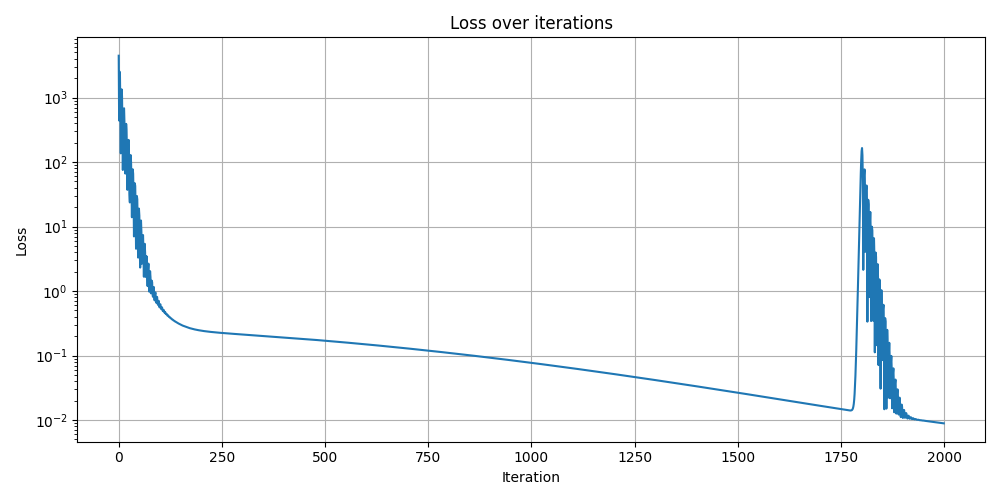

In [88]:
fig, axis = plt.subplots(1, 1, figsize=(10, 5), squeeze = False)

axis[0,0].plot(losses)
axis[0,0].set_title('Loss over iterations')
axis[0,0].set_xlabel('Iteration')
axis[0,0].set_ylabel('Loss')

axis[0,0].grid(True)
axis[0,0].set_yscale('log')
fig.tight_layout()

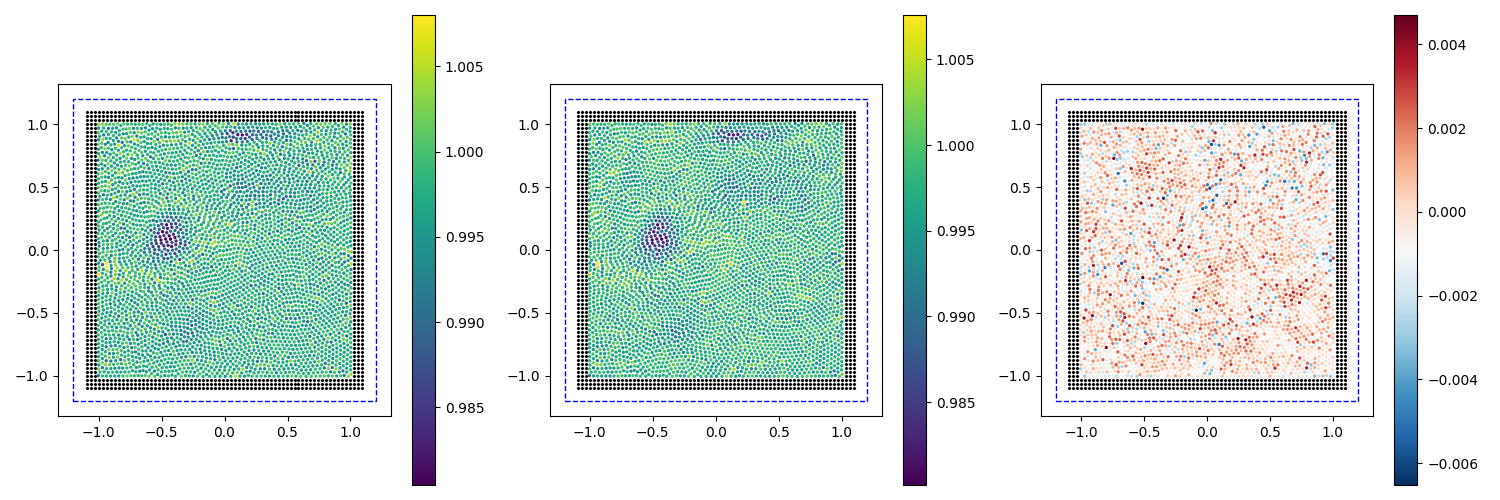

In [89]:
from sphMath.plotting import visualizeParticles
import matplotlib.pyplot as plt


fig, axis = plt.subplots(1, 3, figsize=(15, 5), squeeze = False)

densityPlot = visualizeParticles(fig, axis[0,0],
            particles = currentStates[0], 
            domain = domains[0], 
            quantity = rho / configs[0]['fluid']['rho0'], 
            which = 'fluid',
            # operation = 'curl',
            mapping = '.x',
            cmap = 'viridis',
            visualizeBoth=True,
            kernel = config['kernel'],
            plotDomain = True,
            gridVisualization=False, markerSize=2)

densityPlot = visualizeParticles(fig, axis[0,1],
            particles = currentStates[0], 
            domain = domains[0], 
            quantity = out[:,0], 
            which = 'fluid',
            # operation = 'curl',
            mapping = '.x',
            cmap = 'viridis',
            visualizeBoth=True,
            kernel = config['kernel'],
            plotDomain = True,
            gridVisualization=False, markerSize=2)

densityPlot = visualizeParticles(fig, axis[0,2],
            particles = currentStates[0], 
            domain = domains[0], 
            quantity = out[:,0] - rho / configs[0]['fluid']['rho0'],
            which = 'fluid',
            # operation = 'curl',
            mapping = '.x',
            cmap = 'RdBu_r',
            visualizeBoth=True,
            kernel = config['kernel'],
            plotDomain = True,
            gridVisualization=False, markerSize=2)

fig.tight_layout()

In [80]:
edge_attr

tensor([[ 0.0000,  0.0000],
        [-0.0314,  0.0065],
        [-0.0246, -0.0248],
        ...,
        [ 0.0000,  0.0317],
        [ 0.0317,  0.0000],
        [ 0.0000,  0.0000]], device='cuda:0')

In [67]:
xx = torch.linspace(-1, 1, 101).to('cuda', dtype = torch.float32)
yy = torch.linspace(-1, 1, 101).to('cuda', dtype = torch.float32)
X, Y = torch.meshgrid(xx, yy, indexing='ij')
edge_attr = torch.stack([X.flatten(), Y.flatten()], dim=-1).to('cuda', dtype = torch.float32)

edge_index = torch.stack([torch.arange(X.numel()).to('cuda'), torch.zeros_like(X).flatten().to(torch.int64)])
inputs = torch.ones_like(X).flatten().unsqueeze(-1).to('cuda', dtype = torch.float32)


print(edge_index.shape, edge_attr.shape, inputs.shape)

out, _ = testLayer(
    x = [inputs, inputs],
    edge_index = edge_index,
    edge_attr = edge_attr,
    batches = 1,
)


torch.Size([2, 10201]) torch.Size([10201, 2]) torch.Size([10201, 1])


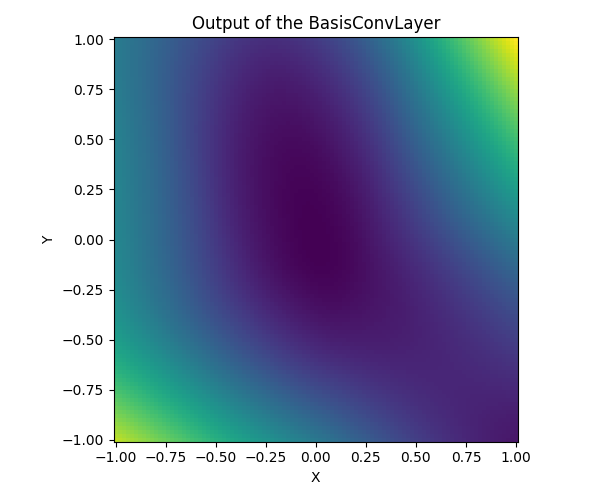

In [68]:
fig, axis = plt.subplots(1, 1, figsize=(6, 5), squeeze = False)

axis[0,0].pcolormesh(X.cpu().numpy(), Y.cpu().numpy(), out[:,0].detach().cpu().numpy().reshape(X.shape), shading='auto', cmap='viridis')

axis[0,0].set_title('Output of the BasisConvLayer')
axis[0,0].set_xlabel('X')
axis[0,0].set_ylabel('Y')
axis[0,0].set_aspect('equal')

fig.tight_layout()